# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **IBRD Credit Scorecard Predictive Engine** |

# II. Notebook Target Definition

This notebook delineates the model training and evaluation stage of IBRD Credit Scorecard Predictive Engine Project. Here, we train and test predictive models on our preprocessed and feature-engineered loan data. We leverage metrics such as confusion matrix, ROC-AUC, and F1 score to gauge model performance. The trade-offs between various types of prediction errors are evaluated to choose the most suitable model, in line with our business needs. The result is a robust model capable of effectively predicting loans most likely to be cancelled or terminated, fostering more informed loan management decisions.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from skopt import BayesSearchCV
from tqdm import tqdm
import hashlib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## III.B. Import Data

In [2]:
X_train = pd.read_pickle('../../data/processed/X_train_ohe.pkl')
X_test = pd.read_pickle('../../data/processed/X_test_ohe.pkl')
y_train = pd.read_pickle('../../data/processed/y_train.pkl')
y_test = pd.read_pickle('../../data/processed/y_test.pkl')

In [3]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
8919,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
289,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2266,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
838,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
94,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0


In [4]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,region:WESTERN AND CENTRAL AFRICA,country:group_a,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_a,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_a,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:40215236.00_to_54947816.00,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor,country_guarantor_status:same
219,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3628,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
497,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
5583,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1556,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [5]:
y_train.head()

8919    0
289     0
2266    0
838     0
94      0
Name: bad, dtype: int32

In [6]:
y_test.head()

219     0
3628    0
497     0
5583    0
1556    0
Name: bad, dtype: int32

# IV. Models Training and Evaluation

## IV.A. Data Shape Inspection

In [7]:
X_train.shape, X_test.shape

((4704, 40), (2017, 40))

In [8]:
y_train.shape, y_test.shape

((4704,), (2017,))

## IV.B. Data Information Inspection

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 8919 to 6608
Data columns (total 40 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  4704 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 4704 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          4704 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         4704 non-null   int32
 4   region:WESTERN AND CENTRAL AFRICA                           4704 non-null   int32
 5   country:group_a                                             4704 non-null   int32
 6   country:group_b                                             4704 non-null   int32
 7   country:group_c                                             4704 non-null   int32
 8   country:group_d     

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 219 to 1162
Data columns (total 40 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC  2017 non-null   int32
 1   region:EUROPE AND CENTRAL ASIA & SOUTH ASIA                 2017 non-null   int32
 2   region:LATIN AMERICA AND CARIBBEAN                          2017 non-null   int32
 3   region:MIDDLE EAST AND NORTH AFRICA                         2017 non-null   int32
 4   region:WESTERN AND CENTRAL AFRICA                           2017 non-null   int32
 5   country:group_a                                             2017 non-null   int32
 6   country:group_b                                             2017 non-null   int32
 7   country:group_c                                             2017 non-null   int32
 8   country:group_d      

In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4704 entries, 8919 to 6608
Series name: bad
Non-Null Count  Dtype
--------------  -----
4704 non-null   int32
dtypes: int32(1)
memory usage: 55.1 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 2017 entries, 219 to 1162
Series name: bad
Non-Null Count  Dtype
--------------  -----
2017 non-null   int32
dtypes: int32(1)
memory usage: 23.6 KB


## IV.C. Training Log

In [13]:
def time_stamp():
    return datetime.now()

def create_logger():
    return {
        "model_name": [],
        "model_uid": [],
        "training_time": [],
        "training_date": [],
        "performance": [],
        "f1_score_avg": [],
        "data_configurations": []
    }

def training_log_updater(current_log, log_path):
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
    except FileNotFoundError:
        with open(log_path, "w") as file:
            file.write("[]")
        with open(log_path, "r") as file:
            last_log = json.load(file)
    last_log.append(current_log)
    with open(log_path, "w") as file:
        json.dump(last_log, file)
    return last_log

def model_training_and_evaluation(models_list, model_prefix, X_train, y_train, X_test, y_test, data_configuration, log_path):
    logger = create_logger()
    for model in tqdm(models_list):
        model_name = model_prefix + "-" + model["model_name"]
        start_time = time_stamp()
        model["model_object"].fit(X_train, y_train)
        finished_time = time_stamp()
        elapsed_time = (finished_time - start_time).total_seconds()
        y_prediction = model["model_object"].predict(X_test)
        performance = classification_report(y_test, y_prediction, output_dict = True)
        original_id = str(start_time) + str(finished_time)
        hashed_id = hashlib.md5(original_id.encode()).hexdigest()
        model["model_uid"] = hashed_id
        logger["model_name"].append(model_name)
        logger["model_uid"].append(hashed_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["data_configurations"].append(data_configuration)
    training_log = training_log_updater(logger, log_path)
    return training_log, models_list

def training_log_to_df_converter(training_log):
    all_training_logs_df = pd.DataFrame()
    for log in tqdm(training_log):
        individual_log_df = pd.DataFrame(log)
        performance_df = pd.json_normalize(individual_log_df["performance"])
        individual_log_df = pd.concat([individual_log_df.drop("performance", axis = 1), performance_df], axis = 1)
        all_training_logs_df = pd.concat([all_training_logs_df, individual_log_df])
    all_training_logs_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    all_training_logs_df.reset_index(inplace = True, drop = True)
    return all_training_logs_df

def best_model_finder(all_training_logs_df, models_list):
    model_object = None
    best_model_info = all_training_logs_df.iloc[0]
    for configuration_data in models_list:
        for model_data in models_list[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    return model_object

def tuned_model_finder(models_list_tuned, tuning_method):
    for model in models_list_tuned:
        if tuning_method in model["model_name"]:
            return model["model_object"]
    print(f"No model found that was tuned with {tuning_method}")
    return None

## IV.D. Baseline Models

In [14]:
X_train_ori = X_train.copy()
X_test_ori = X_test.copy()

In [15]:
reference_categories = ["region:WESTERN AND CENTRAL AFRICA", "country:group_a", "guarantor:group_a", "loan_type:group_a", "principal_amount:40215236.00_to_54947816.00", "country_guarantor_status:same"]

In [16]:
X_train = X_train.drop(columns = reference_categories)
X_test = X_test.drop(columns = reference_categories)
X_train.shape, X_test.shape

((4704, 34), (2017, 34))

In [17]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
8919,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
289,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2266,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
838,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
94,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [18]:
X_test.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
219,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
3628,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
497,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5583,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1556,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [19]:
log_reg_baseline = LogisticRegression(random_state = 777)

In [20]:
models_list = {
    "vanilla": [
        {"model_name": log_reg_baseline.__class__.__name__, "model_object": log_reg_baseline, "model_uid": ""},
    ]
}

In [21]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': ''}]}

### IV.D.1. Vanilla Models

In [22]:
training_log, models_list_vanilla = model_training_and_evaluation(
    models_list["vanilla"],
    "baseline_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "vanilla",
    '../../models/logs/training_log.json')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.38it/s]


In [23]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': 'a8ce6c73f7f1143e60a355350d273e93'}]}

## IV.E. Models Selection

### IV.E.1. Benchmark Performance Review

In [24]:
benchmark = y_train.value_counts(normalize = True)[0]
benchmark

0.9587585034013606

### IV.E.2. Baseline Best Model Performance Review

In [25]:
all_training_logs_df = training_log_to_df_converter(training_log)
all_training_logs_df.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.02it/s]


(1, 23)

In [26]:
all_training_logs_df

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,baseline_model-LogisticRegression,a8ce6c73f7f1143e60a355350d273e93,0.02952,2023-06-30 22:43:15.895030,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017


In [27]:
baseline_best_model = best_model_finder(all_training_logs_df, models_list)
baseline_best_model

LogisticRegression(random_state=777)

In [28]:
baseline_train_prediction = baseline_best_model.predict(X_train)
baseline_test_prediction = baseline_best_model.predict(X_test)

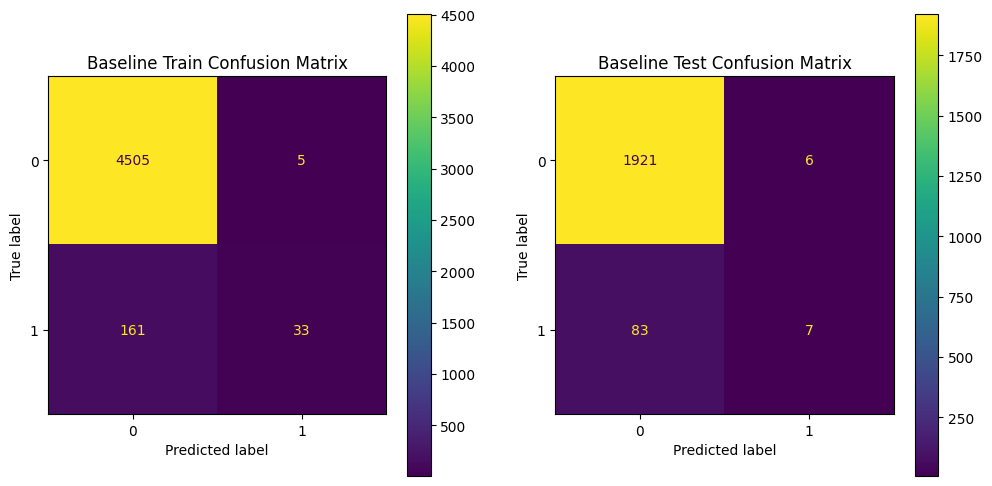

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ConfusionMatrixDisplay.from_predictions(y_train, baseline_train_prediction, ax = ax[0])
ax[0].set_title("Baseline Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, baseline_test_prediction, ax = ax[1])
ax[1].set_title("Baseline Test Confusion Matrix")
plt.show()

In [30]:
def get_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict = True)
    accuracy = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)
    metrics = {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1-score": report["weighted avg"]["f1-score"],
        "accuracy": accuracy,
        "auc_roc": auc_roc
    }
    return metrics

In [31]:
baseline_train_metrics = get_metrics(y_train, baseline_train_prediction)
baseline_train_metrics["dataset"] = "Train"
baseline_test_metrics = get_metrics(y_test, baseline_test_prediction)
baseline_test_metrics["dataset"] = "Test"
baseline_metrics_df = pd.DataFrame([baseline_train_metrics, baseline_test_metrics])
baseline_metrics_df

,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.961492,0.964711,0.953146,0.964711,0.584497,Train
1,0.939837,0.955875,0.939814,0.955875,0.537332,Test


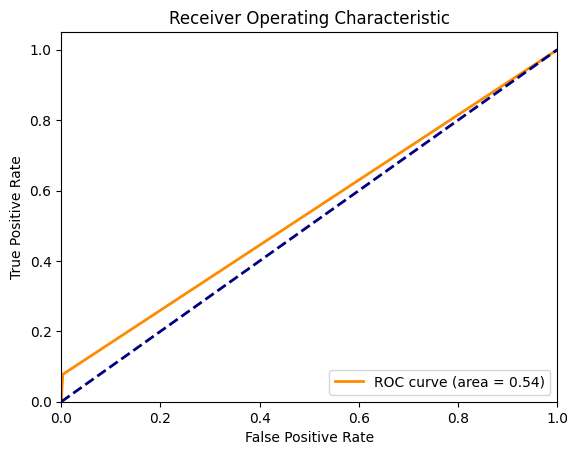

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, baseline_test_prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,
         tpr,
         color = 'darkorange',
         lw = 2,
         label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         color = 'navy',
         lw = 2,
         linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = 'lower right')
plt.show()

### IV.E.3. Baseline Best Model Bias-Variance Trade-Off Review

In [33]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [34]:
def plot_learning_curve(estimator, title, X, y, cross_validation = None):
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            cv = cross_validation,
                                                            n_jobs = -1,
                                                            train_sizes = np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha = 0.1,
                     color = "r")
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha = 0.1,
                     color = "g")
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color = "r",
             label = "Training Score")
    plt.plot(train_sizes,
             test_scores_mean,
             'o-',
             color = "g",
             label = "Cross-Validation Score")
    plt.legend(loc = "best")
    plt.show()

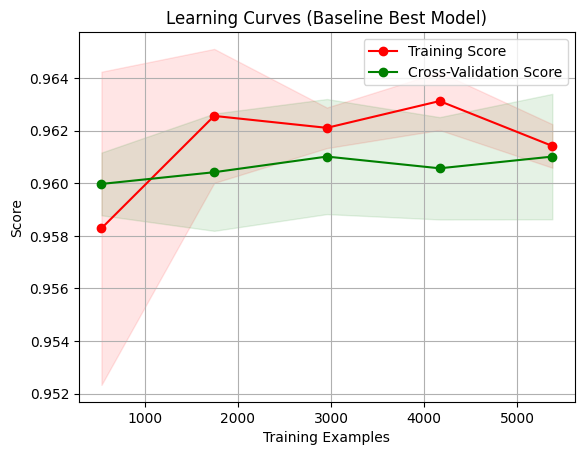

In [35]:
plot_learning_curve(baseline_best_model, "Learning Curves (Baseline Best Model)", X, y, cross_validation = 5)

### IV.E.4. Export Baseline Best Model

In [36]:
# with open("../../models/baseline_best_model.pkl", "wb") as file:
#     pickle.dump(baseline_best_model, file)

## IV.F. Hyperparameter Tuning

### IV.F.1. Bayesian Search Cross Validation

In [37]:
logistic_regression_hyperparams = {
    "C": (1e-5, 1e+5, 'log-uniform'),
    "fit_intercept": [True, False],
    "solver": ['liblinear', 'saga'],
    "penalty": ['l1', 'l2']
}

In [38]:
logistic_regression_bayes_search = BayesSearchCV(
    estimator = baseline_best_model,
    search_spaces = logistic_regression_hyperparams,
    n_iter = 50,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose = 420,
    random_state = 777,
    return_train_score = False
)

In [39]:
models_list["fine-tuned"] = [
    {"model_name": logistic_regression_bayes_search.__class__.__name__ + "-" + logistic_regression_bayes_search.estimator.__class__.__name__, "model_object": logistic_regression_bayes_search, "model_uid": ""}
]

### IV.F.2. Hyperparameter-tuned Model Retraining

In [40]:
training_log, models_list_tuned = model_training_and_evaluation(
    models_list["fine-tuned"],
    "tuned_model",
    X_train,
    y_train,
    X_test,
    y_test,
    "tuned",
    '../../models/logs/training_log.json'
)

  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\investree\.conda\envs\pacmann\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.30s/it]


In [41]:
models_list

{'vanilla': [{'model_name': 'LogisticRegression',
   'model_object': LogisticRegression(random_state=777),
   'model_uid': 'a8ce6c73f7f1143e60a355350d273e93'}],
 'fine-tuned': [{'model_name': 'BayesSearchCV-LogisticRegression',
   'model_object': BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=777), n_jobs=-1,
                 random_state=777, scoring='roc_auc',
                 search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                                'fit_intercept': [True, False],
                                'penalty': ['l1', 'l2'],
                                'solver': ['liblinear', 'saga']},
                 verbose=420),
   'model_uid': 'fdd2e1e34fa2bb53a9ec0a6221773c4c'}]}

### IV.F.3. Hyperparameter-tuned Model Performance Review

In [42]:
all_training_logs_df_tuned = training_log_to_df_converter(training_log)
all_training_logs_df_tuned.shape

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 332.99it/s]


(2, 23)

In [43]:
all_training_logs_df_tuned

,model_name,model_uid,training_time,training_date,f1_score_avg,data_configurations,accuracy,0.precision,0.recall,0.f1-score,0.support,1.precision,1.recall,1.f1-score,1.support,macro avg.precision,macro avg.recall,macro avg.f1-score,macro avg.support,weighted avg.precision,weighted avg.recall,weighted avg.f1-score,weighted avg.support
0,tuned_model-BayesSearchCV-LogisticRegression,fdd2e1e34fa2bb53a9ec0a6221773c4c,46.296771,2023-06-30 22:43:19.452572,0.583787,tuned,0.953892,0.960341,0.992735,0.976269,1927,0.440000,0.122222,0.191304,90,0.700171,0.557479,0.583787,2017,0.937123,0.953892,0.941244,2017
1,baseline_model-LogisticRegression,a8ce6c73f7f1143e60a355350d273e93,0.029520,2023-06-30 22:43:15.895030,0.556641,vanilla,0.955875,0.958583,0.996886,0.977359,1927,0.538462,0.077778,0.135922,90,0.748522,0.537332,0.556641,2017,0.939837,0.955875,0.939814,2017


In [44]:
models_dict_tuned = {"fine-tuned": models_list_tuned}
tuned_best_model = tuned_model_finder(models_dict_tuned['fine-tuned'], "BayesSearchCV")
tuned_best_model

BayesSearchCV(cv=5, estimator=LogisticRegression(random_state=777), n_jobs=-1,
              random_state=777, scoring='roc_auc',
              search_spaces={'C': (1e-05, 100000.0, 'log-uniform'),
                             'fit_intercept': [True, False],
                             'penalty': ['l1', 'l2'],
                             'solver': ['liblinear', 'saga']},
              verbose=420)

In [45]:
tuned_train_prediction = tuned_best_model.predict(X_train)
tuned_test_prediction = tuned_best_model.predict(X_test)

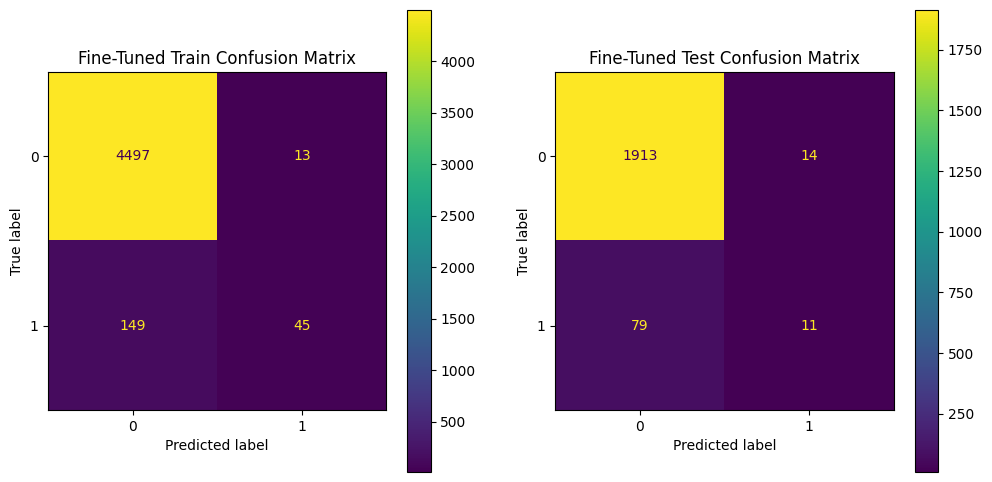

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ConfusionMatrixDisplay.from_predictions(y_train, tuned_train_prediction, ax = ax[0])
ax[0].set_title("Fine-Tuned Train Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_test, tuned_test_prediction, ax = ax[1])
ax[1].set_title("Fine-Tuned Test Confusion Matrix")
plt.show()

In [47]:
tuned_train_metrics = get_metrics(y_train, tuned_train_prediction)
tuned_train_metrics["dataset"] = "Train"
tuned_test_metrics = get_metrics(y_test, tuned_test_prediction)
tuned_test_metrics["dataset"] = "Test"
tuned_metrics_df = pd.DataFrame([tuned_train_metrics, tuned_test_metrics])
tuned_metrics_df

,precision,recall,f1-score,accuracy,auc_roc,dataset
0,0.960008,0.965561,0.956524,0.965561,0.614538,Train
1,0.937123,0.953892,0.941244,0.953892,0.557479,Test


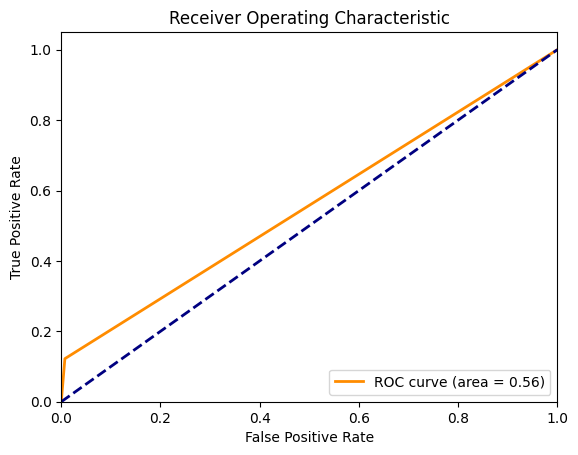

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, tuned_test_prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr,
         tpr,
         color = 'darkorange',
         lw = 2,
         label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],
         [0, 1],
         color = 'navy',
         lw = 2,
         linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc = 'lower right')
plt.show()

### IV.F.4. Export Hyperparameter-tuned Best Model

In [49]:
# with open("../../models/tuned_best_model.pkl", "wb") as file:
#     pickle.dump(tuned_best_model, file)

## IV.G. Probability-based Model Performance Review

In [50]:
def probability_based_metrics(model, X_test, y_test, prediction_threshold):
    y_test_proba = model.predict_proba(X_test)
    y_test_proba = y_test_proba[:, 1]
    y_test_copy = y_test.copy().reset_index(drop = True)
    y_test_proba_df = pd.concat([y_test_copy, pd.DataFrame(y_test_proba, columns = ["y_test_proba"])], axis = 1)
    y_test_proba_df.columns = ["y_test_true", "y_test_proba"]
    y_test_proba_df.index = X_test.index
    y_test_proba_df["y_test_pred"] = np.where(y_test_proba_df["y_test_proba"] >= prediction_threshold, 1, 0)
    precision, recall, thresholds = precision_recall_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])
    AUROC = roc_auc_score(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])
    metrics = {
        "Average Precision": np.mean(precision),
        "Average Recall": np.mean(recall),
        "AUROC": AUROC,
        "Gini": AUROC * 2 - 1,
        "AUC Precision-Recall": auc(recall, precision)
    }
    proba_metrics_df = pd.DataFrame.from_dict(metrics, orient = "index", columns = ["Value"])
    return y_test_proba_df, proba_metrics_df

In [51]:
y_test_proba_df, proba_metrics_df = probability_based_metrics(tuned_best_model, X_test, y_test, prediction_threshold = 0.5)
y_test_proba_df.shape

(2017, 3)

In [52]:
y_test_proba_df.head()

,y_test_true,y_test_proba,y_test_pred
219,0,0.000094,0
3628,0,0.003719,0
497,0,0.005463,0
5583,0,0.007765,0
1556,0,0.008932,0


Text(0.5, 1.0, 'ROC Curve')

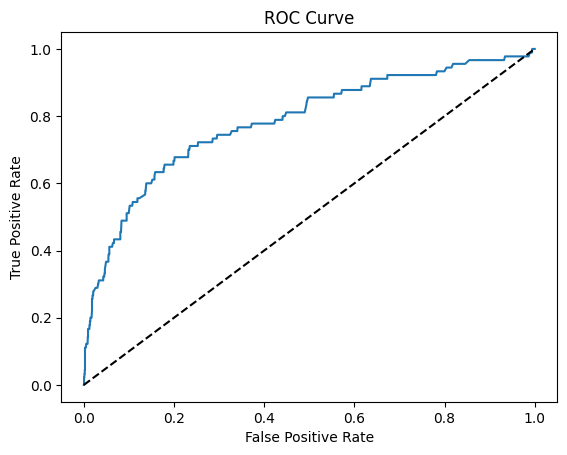

In [53]:
fpr, tpr, threshold = roc_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

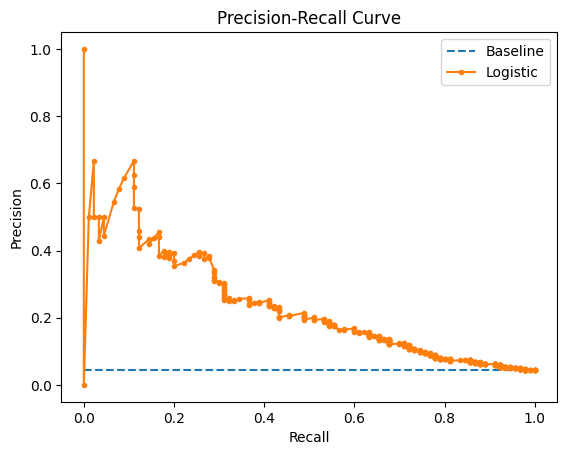

In [54]:
baseline = len(y_test[y_test == 1]) / len(y_test)
precision, recall, thresholds = precision_recall_curve(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_proba"])

plt.title("Precision-Recall Curve")
plt.plot([0, 1], [baseline, baseline], linestyle = '--', label = "Baseline")
plt.plot(recall, precision, marker = '.', label = "Logistic")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

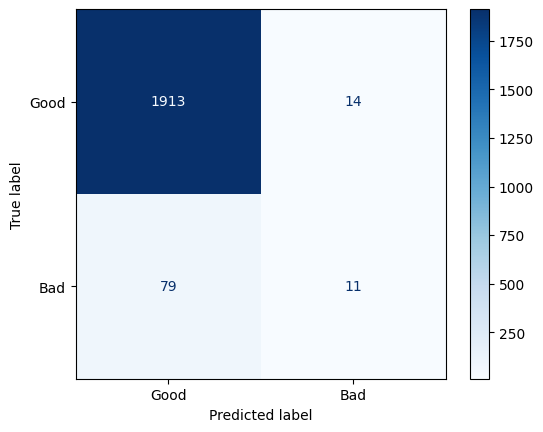

In [55]:
cm = confusion_matrix(y_test_proba_df["y_test_true"], y_test_proba_df["y_test_pred"])
cmd = ConfusionMatrixDisplay(cm, display_labels = ["Good", "Bad"])
cmd.plot(cmap = 'Blues')
plt.show()

# V. Scorecard Creation

## V.A. Scorecard Table Creation

In [56]:
def create_scorecard_first_iteration(model, X_train, reference_categories, min_score = 300, max_score = 850):
    feature_name = X_train.columns.tolist()
    summary_table = pd.DataFrame(columns = ["Feature Name"], data = feature_name)
    summary_table["Coefficients"] = np.transpose(model.coef_)
    summary_table.index = summary_table.index + 1
    summary_table.loc[0] = ["Intercept", model.intercept_[0]]
    summary_table.sort_index(inplace = True)
    reference_categories_df = pd.DataFrame(reference_categories, columns = ["Feature Name"])
    reference_categories_df["Coefficients"] = 0
    scorecard_df = pd.concat([summary_table, reference_categories_df])
    scorecard_df.reset_index(drop = True, inplace = True)
    scorecard_df["Original Feature"] = scorecard_df["Feature Name"].str.split(":").str[0]
    min_sum_coef = scorecard_df.groupby("Original Feature")["Coefficients"].min().sum()
    max_sum_coef = scorecard_df.groupby("Original Feature")["Coefficients"].max().sum()
    scorecard_df["Score - Calculation"] = scorecard_df["Coefficients"] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
    scorecard_df.loc[0, "Score - Calculation"] = ((scorecard_df.loc[0, "Coefficients"] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
    scorecard_df["Score - Preliminary"] = scorecard_df["Score - Calculation"].round()
    scorecard_df["Difference"] = scorecard_df["Score - Preliminary"] - scorecard_df["Score - Calculation"]
    min_sum_score_preliminary = scorecard_df.groupby("Original Feature")["Score - Preliminary"].min().sum()
    max_sum_score_preliminary = scorecard_df.groupby("Original Feature")["Score - Preliminary"].max().sum()
    max_difference_idx = scorecard_df["Difference"].idxmax()
    return scorecard_df, min_sum_score_preliminary, max_sum_score_preliminary, max_difference_idx

In [57]:
scorecard_first_iteration, min_score, max_score, max_difference_idx = create_scorecard_first_iteration(tuned_best_model.best_estimator_, X_train, reference_categories, min_score = 300, max_score = 850)
scorecard_first_iteration

,Feature Name,Coefficients,Original Feature,Score - Calculation,Score - Preliminary,Difference
0,Intercept,-8.518029,Intercept,555.020601,555.0,-0.020601
1,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA...,-0.077322,region,-1.190015,-1.0,0.190015
2,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,-0.208033,region,-3.201713,-3.0,0.201713
3,region:LATIN AMERICA AND CARIBBEAN,-0.548518,region,-8.441923,-8.0,0.441923
4,region:MIDDLE EAST AND NORTH AFRICA,-0.205176,region,-3.157739,-3.0,0.157739
5,country:group_b,0.415893,country,6.400777,6.0,-0.400777
6,country:group_c,1.576652,country,24.265347,24.0,-0.265347
7,country:group_d,1.530737,country,23.558695,24.0,0.441305
8,country:group_e,1.583475,country,24.370347,24.0,-0.370347
9,country:group_f,5.017039,country,77.214360,77.0,-0.214360


In [58]:
print("Scorecard First Iteration Minimum Score: ", min_score)
print("Scorecard First Iteration Maximum Score: ", max_score)
print("The Maximum Difference Location: ", max_difference_idx)

Scorecard First Iteration Minimum Score:  300.0
Scorecard First Iteration Maximum Score:  850.0
The Maximum Difference Location:  16


In [59]:
def create_final_scorecard(scorecard_df, max_difference_idx):
    scorecard_df["Score - Final"] = scorecard_df["Score - Preliminary"]
    # scorecard_df.loc[0, "Score - Final"] = scorecard_df.loc[0, "Score - Final"] - 1
    # scorecard_df.loc[max_difference_idx, "Score - Final"] = scorecard_df.loc[max_difference_idx, "Score - Final"] - 1
    min_sum_score_final = scorecard_df.groupby("Original Feature")["Score - Final"].min().sum()
    max_sum_score_final = scorecard_df.groupby("Original Feature")["Score - Final"].max().sum()
    return scorecard_df, min_sum_score_final, max_sum_score_final

In [60]:
final_scorecard, min_score_final, max_score_final = create_final_scorecard(scorecard_first_iteration, max_difference_idx)
final_scorecard

,Feature Name,Coefficients,Original Feature,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,Intercept,-8.518029,Intercept,555.020601,555.0,-0.020601,555.0
1,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA...,-0.077322,region,-1.190015,-1.0,0.190015,-1.0
2,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,-0.208033,region,-3.201713,-3.0,0.201713,-3.0
3,region:LATIN AMERICA AND CARIBBEAN,-0.548518,region,-8.441923,-8.0,0.441923,-8.0
4,region:MIDDLE EAST AND NORTH AFRICA,-0.205176,region,-3.157739,-3.0,0.157739,-3.0
5,country:group_b,0.415893,country,6.400777,6.0,-0.400777,6.0
6,country:group_c,1.576652,country,24.265347,24.0,-0.265347,24.0
7,country:group_d,1.530737,country,23.558695,24.0,0.441305,24.0
8,country:group_e,1.583475,country,24.370347,24.0,-0.370347,24.0
9,country:group_f,5.017039,country,77.214360,77.0,-0.214360,77.0


In [61]:
print("Final Scorecard Minimum Score: ", min_score_final)
print("Final Scorecard Maximum Score: ", max_score_final)

Final Scorecard Minimum Score:  300.0
Final Scorecard Maximum Score:  850.0


In [68]:
X_train.head()

,region:EASTERN AND SOUTHERN AFRICA & EAST ASIA AND PACIFIC,region:EUROPE AND CENTRAL ASIA & SOUTH ASIA,region:LATIN AMERICA AND CARIBBEAN,region:MIDDLE EAST AND NORTH AFRICA,country:group_b,country:group_c,country:group_d,country:group_e,country:group_f,country:group_g,country:group_h,country:group_i,country:group_j,country:group_k,guarantor:group_b,guarantor:group_c,guarantor:group_d,guarantor:group_e,guarantor:group_f,guarantor:group_g,guarantor:group_h,guarantor:group_i,guarantor:group_j,loan_type:group_b,loan_type:group_c,loan_type:group_d,principal_amount:-inf_to_1978840.31,principal_amount:1978840.31_to_8013587.75,principal_amount:23240000.00_to_40215236.00,principal_amount:249441952.00_to_inf,principal_amount:54947816.00_to_249441952.00,principal_amount:8013587.75_to_23240000.00,country_guarantor_status:differ,country_guarantor_status:no_guarantor
8919,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
289,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2266,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
838,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
94,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


In [62]:
def get_score(X_test, scorecard):
    X_test_copy = X_test.copy()
    # add intercept
    X_test_copy.insert(0, 'Intercept', 1)
    
    # Get missing columns in the test set
    missing_cols = set(scorecard['Feature Name']) - set(X_test_copy.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        X_test_copy[c] = 0
    # Ensure the order of column in the test set is in the same order than in scorecard
    X_test_copy = X_test_copy[scorecard['Feature Name']]
    
    # Reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
    scorecard_scores = scorecard['Score - Final'].values.reshape(scorecard.shape[0], 1)
    
    # matrix dot multiplication of test set with scorecard scores
    y_scores = X_test_copy.dot(scorecard_scores)
    
    return y_scores


In [64]:
y_scores = get_score(X_test, final_scorecard)
y_scores.head()

,0
219,543.0
3628,600.0
497,606.0
5583,612.0
1556,614.0


In [65]:
y_scores.max()

0    719.0
dtype: float64

In [66]:
y_scores.min()

0    375.0
dtype: float64

In [67]:
y_scores = get_score(X_train, final_scorecard)
y_scores.head()

,0
8919,619.0
289,547.0
2266,599.0
838,621.0
94,554.0
